# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [3]:
import numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?
    # Se puede realizar indexando self.name

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?
    # Por haber perdido la estructura original con el flatten

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat) # Q1

In [5]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    # Para obtener la cantidad de ocurrencias de cada valor en y
    # al dividir por y.size se obtiene la frequencia relativa de cada clase
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?
    # Requerimientos de fit params:
    # 1. Tener las clases ya codificadas en valores numéricos
    # 2. Se utiliza log_a_priori COMPLETAR COMO SE UTILIZA

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [47]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Necesitamos indexar X con un escalar en lugar de un vector
    # Q6: por que se usa bias=True en vez del default bias=False?
    # Al ser máxima verosimilitud (MLE), deseamos dividir por n en lugar de (n - 1)
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?
    # Las observaciones son vectores columnas,
    # por lo que queremos promediar sobre las columnas en lugar de las filas

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [7]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [8]:
# hiperparámetros
rng_seed = 6543

In [9]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [10]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [11]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

In [12]:
# check clases names
np.unique(y_full)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [13]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [14]:
qda = QDA()

qda.fit(train_x, train_y)

In [15]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [16]:
%%timeit -n 500

qda.predict(test_x)

1.42 ms ± 26.4 μs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [17]:
%%timeit -n 500

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

1.58 ms ± 4 μs per loop (mean ± std. dev. of 7 runs, 500 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

Comparación con distribuciones del dataset completo:

In [48]:
distributions = [
    np.array([1.0/3.0, 1.0/3.0, 1.0/3.0]),
    np.array([0.9, 0.05, 0.05]),
    np.array([0.05, 0.9, 0.05]),
    np.array([0.05, 0.05, 0.9]),
]
for idx, distribution in enumerate(distributions):
    qda = QDA()
    qda.fit(train_x, train_y, a_priori=distribution)
    qda.predict(test_x)
    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    print(f"For distribution {idx}: Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
print(qda.encoder.names)

For distribution 0: Train (apparent) error is 0.0222 while test error is 0.0167
For distribution 1: Train (apparent) error is 0.0222 while test error is 0.0167
For distribution 2: Train (apparent) error is 0.0333 while test error is 0.0000
For distribution 3: Train (apparent) error is 0.0333 while test error is 0.0500
['setosa' 'versicolor' 'virginica']


In [19]:
data = np.column_stack((X_full, y_full))
column_names = [f"feature_{i+1}" for i in range(X_full.shape[1])] + ["target"]
df = pd.DataFrame(data, columns=column_names)
df.head()

,feature_1,feature_2,feature_3,feature_4,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


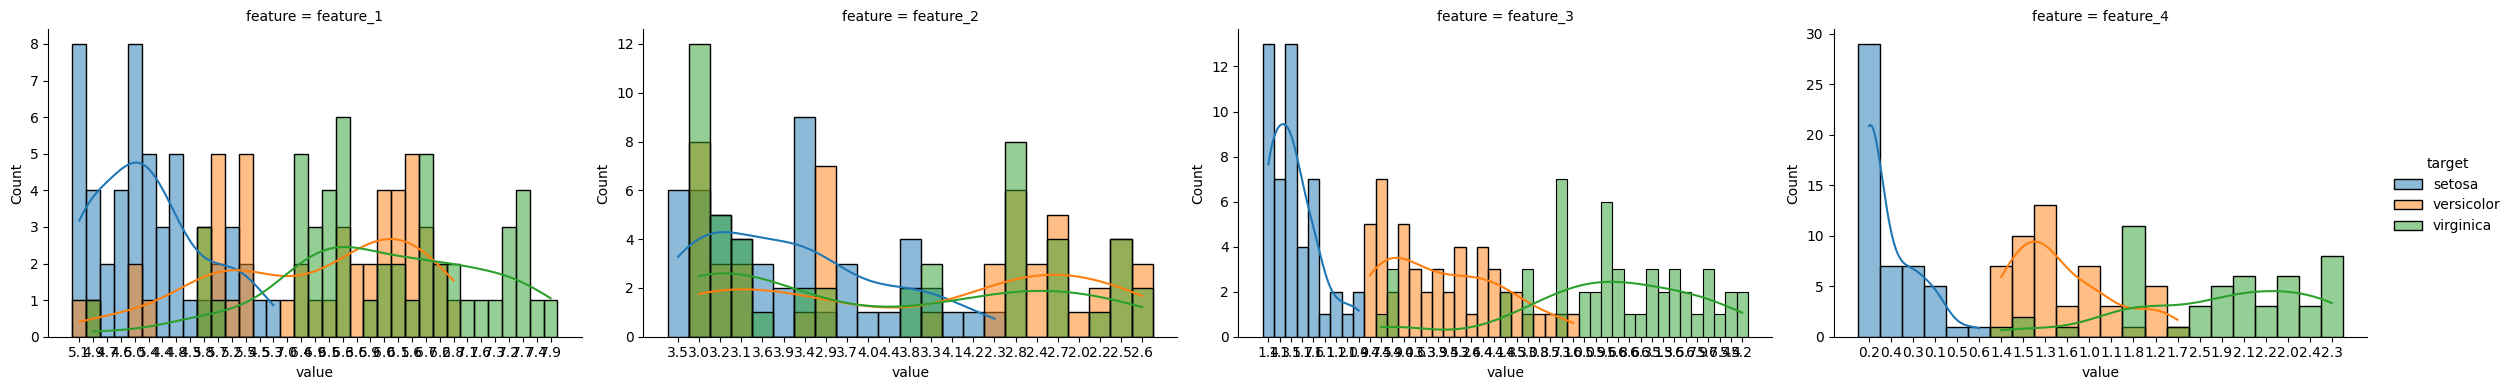

In [20]:
df_long = df.melt(id_vars="target", var_name="feature", value_name="value")
g = sns.FacetGrid(df_long, col="feature", hue="target", sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, "value", kde=True, multiple="stack")
g.add_legend()
plt.show()

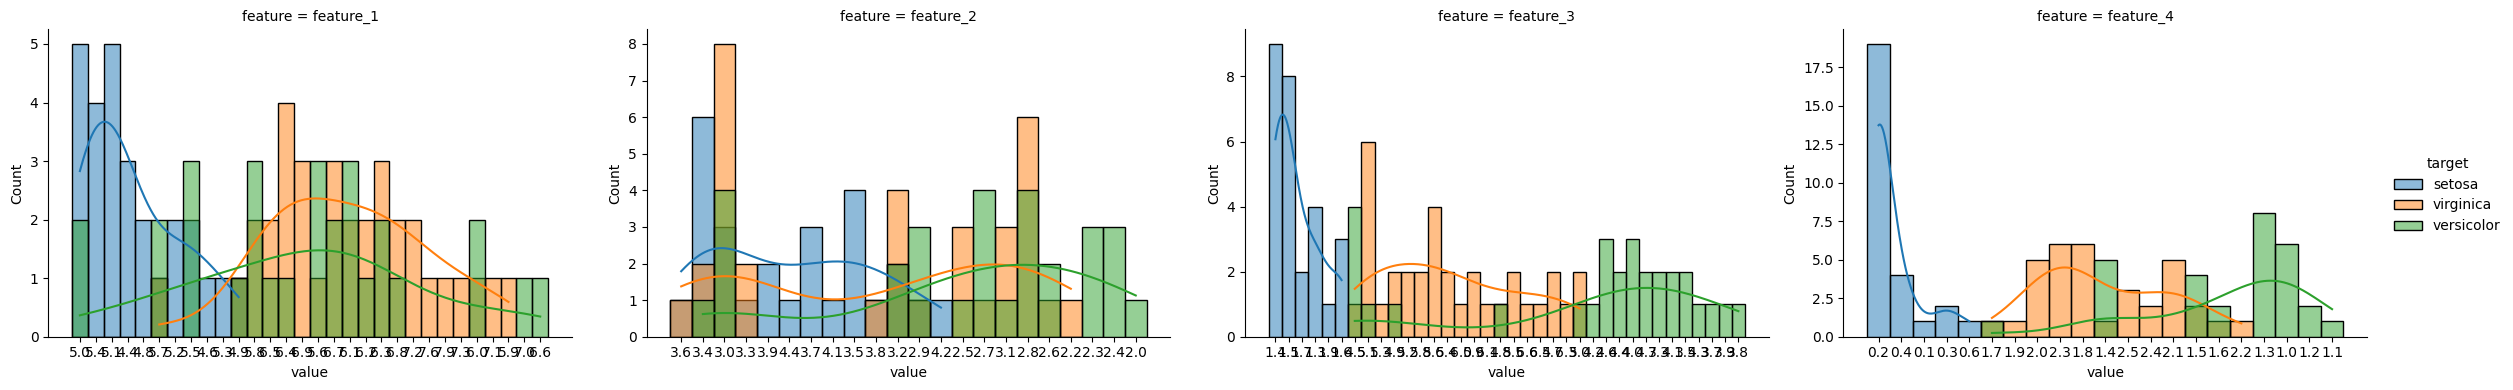

In [21]:
data_train = np.column_stack((train_x.T, train_y.T))
df_train = pd.DataFrame(data_train, columns=column_names)
df_long = df_train.melt(id_vars="target", var_name="feature", value_name="value")
g = sns.FacetGrid(df_long, col="feature", hue="target", sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, "value", kde=True, multiple="stack")
g.add_legend()
plt.show()

2. Repetir el punto anterior para el dataset *penguin*.

In [54]:
distributions = [
    np.array([1.0/3.0, 1.0/3.0, 1.0/3.0]),
    np.array([0.9, 0.05, 0.05]),
    np.array([0.05, 0.9, 0.05]),
    np.array([0.05, 0.05, 0.9]),
]
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)
for idx, distribution in enumerate(distributions):
    qda = QDA()
    qda.fit(train_x, train_y, a_priori=distribution)
    qda.predict(test_x)
    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    print(f"For distribution {idx}: Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
print(qda.encoder.names)

For distribution 0: Train (apparent) error is 0.0098 while test error is 0.0073
For distribution 1: Train (apparent) error is 0.0195 while test error is 0.0219
For distribution 2: Train (apparent) error is 0.0098 while test error is 0.0219
For distribution 3: Train (apparent) error is 0.0098 while test error is 0.0073
['Adelie' 'Chinstrap' 'Gentoo']


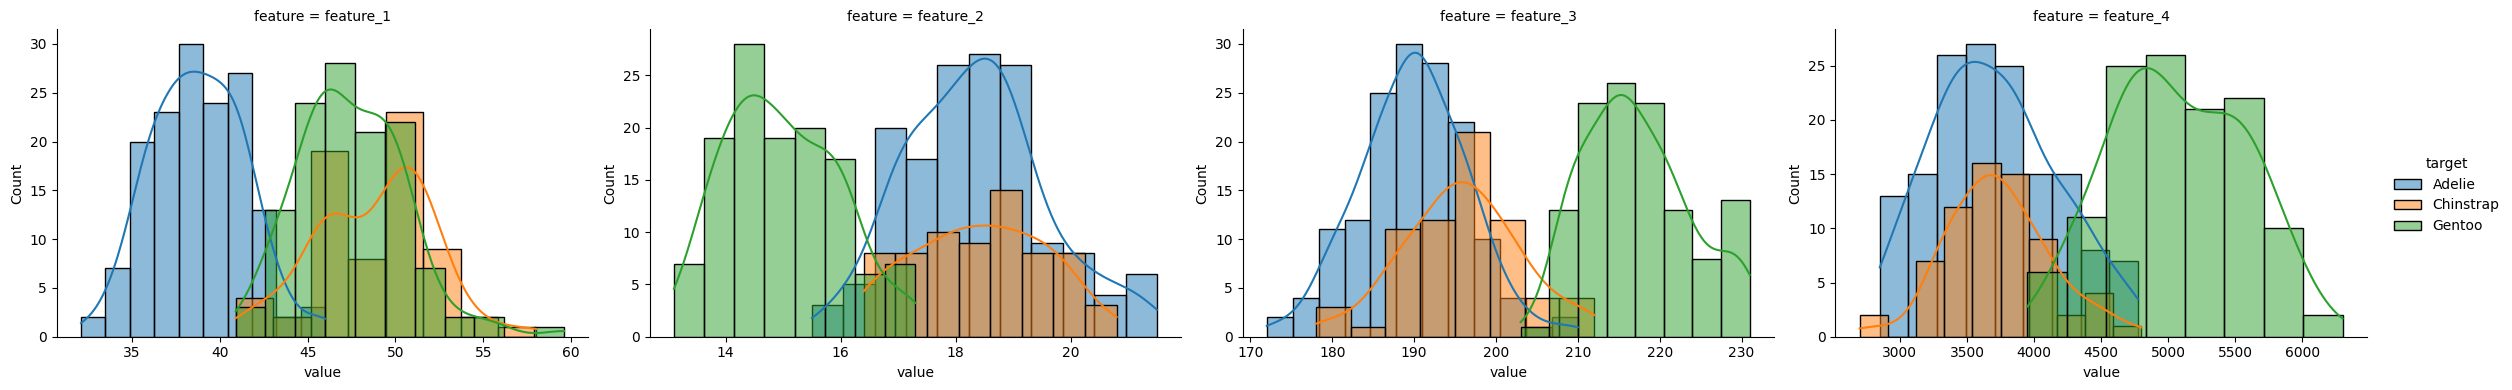

In [24]:
data = np.column_stack((X_full, y_full))
column_names = [f"feature_{i+1}" for i in range(X_full.shape[1])] + ["target"]
df = pd.DataFrame(data, columns=column_names)
df_long = df.melt(id_vars="target", var_name="feature", value_name="value")
g = sns.FacetGrid(df_long, col="feature", hue="target", sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, "value", kde=True, multiple="stack")
g.add_legend()
plt.show()

3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

In [52]:
class LDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    fr = np.bincount(y.flatten().astype(int)) / y.size
    cov = np.sum([fr[idx] * np.cov(X[:,y.flatten()==idx], bias=True) for idx in range(len(self.log_a_priori))], axis=0)
    self.inv_cov = inv(cov)
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(self.inv_cov)) -0.5 * unbiased_x.T @ self.inv_cov @ unbiased_x

In [53]:
distributions = [
    np.array([1.0/3.0, 1.0/3.0, 1.0/3.0]),
    np.array([0.9, 0.05, 0.05]),
    np.array([0.05, 0.9, 0.05]),
    np.array([0.05, 0.05, 0.9]),
]
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)
for idx, distribution in enumerate(distributions):
    qda = LDA()
    qda.fit(train_x, train_y, a_priori=distribution)
    qda.predict(test_x)
    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    print(f"For distribution {idx}: Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
print(qda.encoder.names)

For distribution 0: Train (apparent) error is 0.0222 while test error is 0.0167
For distribution 1: Train (apparent) error is 0.0222 while test error is 0.0167
For distribution 2: Train (apparent) error is 0.0444 while test error is 0.0333
For distribution 3: Train (apparent) error is 0.0333 while test error is 0.0333
['setosa' 'versicolor' 'virginica']


In [55]:
distributions = [
    np.array([1.0/3.0, 1.0/3.0, 1.0/3.0]),
    np.array([0.9, 0.05, 0.05]),
    np.array([0.05, 0.9, 0.05]),
    np.array([0.05, 0.05, 0.9]),
]
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)
for idx, distribution in enumerate(distributions):
    qda = LDA()
    qda.fit(train_x, train_y, a_priori=distribution)
    qda.predict(test_x)
    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    print(f"For distribution {idx}: Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
print(qda.encoder.names)

For distribution 0: Train (apparent) error is 0.0098 while test error is 0.0073
For distribution 1: Train (apparent) error is 0.0195 while test error is 0.0219
For distribution 2: Train (apparent) error is 0.0146 while test error is 0.0219
For distribution 3: Train (apparent) error is 0.0098 while test error is 0.0073
['Adelie' 'Chinstrap' 'Gentoo']



4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.

2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.